# Mixtures of Gaussian processes with GPclust


This notebook accompanies the paper

**Nonparameteric Clustering of Structured Time Series**  
_James Hensman, Magnus Rattray and Neil D. Lawrence_  
IEEE TPAMI 2014

The code is available at <https://github.com/jameshensman/gpclust> . The GPclust module depends on [GPy](https://github.com/SheffieldML/GPy).  

The hierachical Gaussian process model was fleshed out in 

**Hierarchical Bayesian modelling of gene expression time series  
across irregularly sampled replicates and clusters**  
_James Hensman, Neil D. Lawrence and Magnus Rattray_

http://www.biomedcentral.com/1471-2105/14/252

A simple implementation of hierarchical GPs is available as part of GPy. You may also be interested in the related notebook on hierarchical GPs.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'#'svg' would be better, but eats memory for these big plots.
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import GPclust
import GPflow

## A simple sinusoid dataset

Here's a simulated dataset that contains the simple features that we expect to have in real data sets: smooth processes (here, sinusoids) corrupted by further smooth processes (here, more sinusoids) as well as noise. 

In [2]:
#generate a data set. Here's the sinusoid demo from the manuscript.
Nclust = 10
Nx = 12
Nobs = [np.random.randint(20,31) for i in range(Nclust)] #a random number of realisations in each cluster
X = np.random.rand(Nx,1)
X.sort(0)

#random frequency and phase for each cluster
base_freqs = 2*np.pi + 0.3*(np.random.rand(Nclust)-.5)
base_phases = 2*np.pi*np.random.rand(Nclust)
means = np.vstack([np.tile(np.sin(f*X+p).T,(Ni,1)) for f,p,Ni in zip(base_freqs,base_phases,Nobs)])

#add a lower frequency sinusoid for the noise
freqs = .4*np.pi + 0.01*(np.random.rand(means.shape[0])-.5)
phases = 2*np.pi*np.random.rand(means.shape[0])
offsets = 0.3*np.vstack([np.sin(f*X+p).T for f,p in zip(freqs,phases)])
Y = means + offsets + np.random.randn(*means.shape)*0.05

In the plot below, we show the underlying function for each cluster as a smooth red function, and the data associated with the cluster as thinly connected blue crosses. 

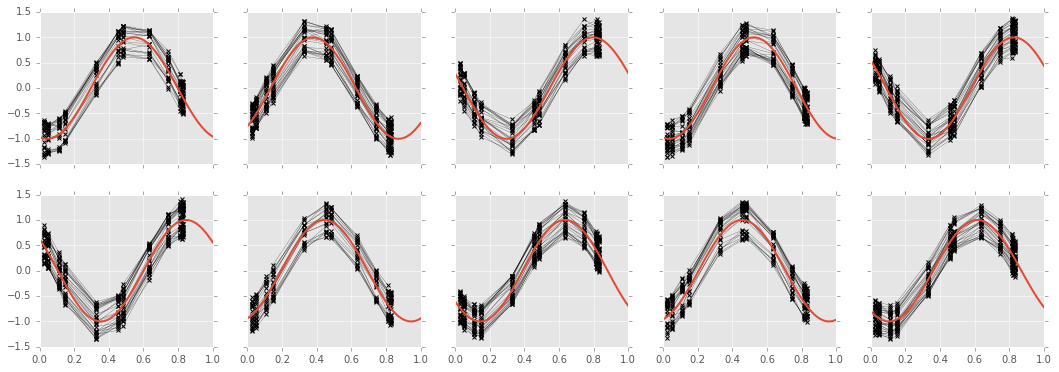

In [3]:
#plotting. 
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
f, axes = plt.subplots(2, Nclust//2, figsize=(18,6), sharex=True, sharey=True)
index_starts = np.hstack([0, np.cumsum(Nobs[:-1])])
index_stops = np.cumsum(Nobs)
for n, ax in enumerate(axes.flatten()):
    ax.plot(X, Y[index_starts[n]:index_stops[n]].T, 'k', marker='x',ms=4, mew=1, linewidth=0.2)
    ax.plot(x_plot, np.sin(base_freqs[n]*x_plot+base_phases[n]), linewidth=2)
    

Constructing and optimizing a model
---

Now that we have generated a data set, it's straightforward to build and optimize a clustering model. First, we need to build two GPy kernels (covariance functions), which will be used to model the underlying function and the replication noise, respecively. We'll take a wild stab at the parameters of these covariances, and let the model optimize them for us later. 

The two kernels model the *underlying* function of the cluster, and the deviations of each gene from that underlying function. If we believe that the only corruption of the data from the cluster mean is i.i.d. noise, we can specify a `GPy.kern.White` covariance. In practise, it's helpful to allow correlated noise. The model of any cluster of genes then has a hierarchical structure, with the unknown cluster-specific mean drawn from a GP, and then each gene in that cluster being drawn from a GP with said unknown mean function. 

To optimize the model with the default optimization settings, we call m.optimize(). To invoke the recommended merge-split procedure, call m.systematic_splits(). Note that during the splitting procedure, many calls are made to the optimize function. 

In [4]:
k_underlying = GPflow.kernels.RBF(input_dim=1, variance=0.1, lengthscales=0.1)
k_corruption = GPflow.kernels.RBF(input_dim=1, variance=0.01, lengthscales=0.1) + GPflow.kernels.White(1, variance=0.001)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, num_clusters=10, prior_Z='symmetric', alpha=1.0)
m.optimize()
m.systematic_splits(verbose=False)

iteration 1 bound=-1286.93301174 grad=12630.8359152, beta=0
iteration 2 bound=886.230785165 grad=74440.5659519, beta=1.98999507478
iteration 3 bound=1146.84782199 grad=672.570327268, beta=0.0
iteration 4 bound=1197.14633112 grad=79.2540375555, beta=0.0
iteration 5 bound=1225.01084593 grad=47.9138711595, beta=0.0
iteration 6 bound=1228.86180131 grad=8.2575261045, beta=0.0
iteration 7 bound=1229.35785324 grad=0.745913783462, beta=0.0996177073752
iteration 8 bound=1229.50114015 grad=0.12428689097, beta=0.184238521707
iteration 9 bound=1229.58050522 grad=0.0683230090963, beta=0.374367726478
iteration 10 bound=1229.59762648 grad=0.0184485295315, beta=0.373776325513
iteration 11 bound=1229.59813486 grad=0.000762238583481, beta=0.0178804934623
iteration 12 bound=1229.59822901 grad=0.00011341774416, beta=0.270372899777
iteration 13 bound=1229.59824669 grad=2.67574059186e-05, beta=0.0
iteration 14 bound=1229.59825008 grad=3.94422890555e-06, beta=0.255193328168
iteration 15 bound=1229.5982507 gr

Plotting and examining the posterior
---
The model has quite extensive plotting built in, with various options for colour, display of the data as points or connected lines, etc. Here we find that the model manages to separate all but two of the true clusters. The number of 'genes' found in each cluster is labeled in the corner of each plot. 

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


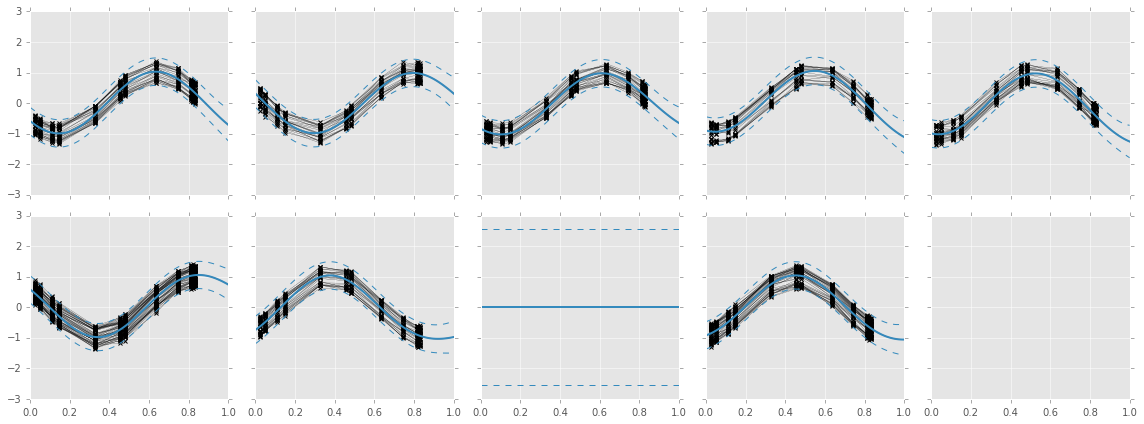

In [5]:

def plot(layout=None, figsize=(12,12)):
    if layout is None:
        num_x = int(np.ceil(np.sqrt(m.num_clusters)))
        num_y = m.num_clusters // num_x
    else:
        num_x, num_y = layout
    f, axes = plt.subplots(num_x, num_y, figsize=figsize, sharex=True, sharey=True, tight_layout=True)
    
    x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
    mu, var = m.predict_components(x_plot)
    phi = m.get_phi()
    
    for i, (mu_i, var_i, ax), in enumerate(zip(mu, var, axes.flatten())):
        ax.plot(x_plot[:,0], mu_i)

        ind = np.argmax(phi, 1) == i
        if np.any(ind):
            ax.plot(X, Y[ind, :].T, 'k', ms=4, mew=1, marker='x', lw=0.2)
        line, = ax.plot(x_plot[:,0], mu_i, lw=2)
        ax.plot(x_plot[:,0], mu_i[:,0] + 2*np.sqrt(np.diag(var_i)), '--', lw=1, color=line.get_color())
        ax.plot(x_plot[:,0], mu_i[:,0] - 2*np.sqrt(np.diag(var_i)), '--', lw=1, color=line.get_color())
plot((2,5), (16,6))

Structure is important
---
Why do we have to specify two kernels in GPclust? The first kernel describes the properties of the functions which underly each cluster. The second describes the properties of the functions which describe how each time-course (gene) deviates from the cluster. 

This structure is important: if we model the deviation of each time-course from the cluster as simply noise, it's more difficult to infer the correct clusters. Such a model can be constructed in GPclust by using a white (noise) kernel for the structure, as follows.


In [8]:
#exactly as above, but with a white-noise kernel for the structure.
k_underlying = GPflow.kernels.RBF(input_dim=1, variance=0.1, lengthscales=0.1)
k_corruption = GPflow.kernels.White(1, variance=0.1)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, num_clusters=10, prior_Z='symmetric', alpha=1.0)
m.optimize()

iteration 1 bound=-1542.39853939 grad=1229.09221384, beta=0
iteration 2 bound=-805.644491319 grad=11649.019057, beta=1.05380923816
iteration 3 bound=-656.424452968 grad=336.809688822, beta=0.0
iteration 4 bound=-601.646479515 grad=105.72696807, beta=0.0
iteration 5 bound=-584.83252302 grad=32.9170721709, beta=0.0
iteration 6 bound=-580.810791674 grad=5.12211104939, beta=0.0714319957153
iteration 7 bound=-577.864847959 grad=2.21006742338, beta=0.29834002331
iteration 8 bound=-574.422392514 grad=2.59168008806, beta=0.0
iteration 9 bound=-556.453073824 grad=6.55931307769, beta=1.9769944589
iteration 10 bound=-540.328226545 grad=14.692795112, beta=1.36180871925
iteration 11 bound=-535.480343134 grad=43.0546704626, beta=0.713728405707
iteration 12 bound=-530.285666475 grad=5.84725530033, beta=0.0
iteration 13 bound=-526.365336291 grad=2.77778313692, beta=0.585584892429
iteration 14 bound=-523.967628715 grad=2.56873346039, beta=0.0
iteration 15 bound=-521.80741939 grad=2.38605699764, beta=0.

In [9]:
m.systematic_splits(verbose=False)

InvalidArgumentError: Input matrix is not invertible.
	 [[Node: model.build_likelihood_19/BatchMatrixTriangularSolve = BatchMatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](model.build_likelihood_19/BatchCholesky, model.build_likelihood_19/Tile)]]
Caused by op u'model.build_likelihood_19/BatchMatrixTriangularSolve', defined at:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2815, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-6b4f0e7acce1>", line 1, in <module>
    m.systematic_splits(verbose=False)
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_mixture.py", line 206, in systematic_splits
    self.recursive_splits(kk, verbose=verbose)
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_mixture.py", line 213, in recursive_splits
    success = self.try_split(k, verbose=verbose, optimize_params=optimize_params)
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_mixture.py", line 174, in try_split
    self.optimize(maxiter=maxiter, verbose=verbose)
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_vb.py", line 73, in optimize
    bound_old, grad_old, natgrad_old = self.vb_bound_grad_natgrad()
  File "/Users/danmarthaler/GPflow/GPflow/param.py", line 515, in runnable
    storage['tf_result'] = tf_method(instance, *storage['tf_args'])
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_mixture.py", line 102, in vb_bound_grad_natgrad
    bound = self.build_likelihood()
  File "/Users/danmarthaler/GPflow/GPflow/scoping.py", line 41, in runnable
    return f(*args, **kwargs)
  File "/Users/danmarthaler/GPclust/GPclust/MOHGP.py", line 73, in build_likelihood
    tmp = tf.batch_matrix_triangular_solve(C_chols, L_tiled, lower=True)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 252, in batch_matrix_triangular_solve
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


In [ ]:
plot()

Here we can see that the procedure finds too many clusters (we know that the ground truth is that there are 10). This is because without the ability to model the deviation from the cluster mean in a structured fashion, that structure appears as additional clusters. 

This point is exaggerated a little by the toy data that we have generated, but the same issue exists in real data. For more details and consideration of the cluster structure, see the subsequent notebook on clustering Drosophila development. 